In [ ]:
# Install dlroms if needed

try:
    from dlroms import *
except ImportError:
    !pip install git+https://github.com/NicolaRFranco/dlroms.git
    from dlroms.colab import setup
    setup()

All complementary packages have been successfully installed. Please restart Runtime in order to operate.


In [ ]:
# Import libraries

import numpy as np
from dlroms import *
from dlroms.dnns import *
import numpy.random as rnd
import matplotlib.pyplot as plt
import torch
from dolfin import *

In [ ]:
# Flags

plotOn = False
generateData = False

device = torch.device('cuda:0')

# Random seeds

rnd.seed(0)
torch.manual_seed(0)

In [ ]:
# Domain and mesh definition

print('Generating mesh and finite element space...')

h = 0.01 													# Mesh size
n = int(1 / h)												# Number of cells

# Generate mesh with gmsh
# D = fe.rectangle((0,0), (1,1)) 							# Square domain
# mesh = fe.mesh(D, stepsize=h) 							# Mesh (stepsize parameter available with gmsh)

# Generate mesh with FEniCS
mesh = fe.unitsquaremesh(n, n)								# Mesh

V = fe.space(mesh, 'CG', 1) 								# Continuous piecewise linear finite elements
Nh = V.dim() 												# Space dimension (number of dofs)

u_D = Expression('0.01', degree=0) 							# Function at the boundary

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary) 							# Dirichlet boundary conditions

Generating mesh and finite element space...


In [ ]:
# Sampling of the training and test sets

training_size = 1200
test_size = 5000

if generateData:

	print('Sampling training and test sets...')

	mu_train = np.zeros((training_size, 4))						# Training set

	for i in range(training_size):
		mu_train[i] = rnd.uniform(0., 1., size=(1, 4))

	mu_test = np.zeros((test_size, 4))							# Test set

	for i in range(test_size):
		mu_test[i] = rnd.uniform(0., 1., size=(1, 4))

	mu1, mu2, mu3, mu4 = mu_train[:, 0], mu_train[:, 1], mu_train[:, 2], mu_train[:, 3]
	mu1t, mu2t, mu3t, mu4t = mu_test[:, 0], mu_test[:, 1], mu_test[:, 2], mu_test[:, 3]

In [ ]:
# Snapshots generation

if generateData:

	print('Generating snapshots...')

	u_train = np.zeros((training_size, Nh))

	for i in range(training_size):

		if i % 100 == 0:
			print('Snapshot {}/{}'.format(i, training_size))

		sigma = Expression('6 + 5 * tanh(20 * (x[1] + 10 * mu1 * x[0] * (x[0] - 1) * (x[0] - mu2) * (x[0] - mu3) - 0.5))',
							degree=2, mu1=mu1[i], mu2=mu2[i], mu3=mu3[i])											# Diffusion coefficient

		if plotOn and i % 100 == 0:
			plt.figure(figsize=(4, 3))
			fe.plot(interpolate(sigma, V).vector(), V, colorbar=True)												# Plot diffusion coefficient
			plt.title('sigma @ mu = ({:.2f}, {:.2f}, {:.2f}, {:.2f})'.format(mu1[i], mu2[i], mu3[i], mu4[i]))
			plt.show()

		beta = Expression(('10 * cos(2 * pi * mu4)', '10 * sin(2 * pi * mu4)'), degree=2, mu4=mu4[i], pi=np.pi)		# Advection coefficient

		f = Expression('100 * (x[0] * x[1] - x[1] * x[1])', degree=2)												# Source term

		u = TrialFunction(V)																						# Trial function
		v = TestFunction(V)																							# Test function

		F = sigma * dot(grad(u), grad(v)) * dx + dot(beta, grad(u)) * v * dx - f * v * dx							# Variational formulation
		a, L = lhs(F), rhs(F)

		u = Function(V)																								# Solution function

		solve(a == L, u, bc)																						# Solution of the variational problem

		if plotOn and i % 100 == 0:
			plt.figure(figsize=(4, 3))
			fe.plot(u.vector(), V, colorbar=True)																	# Plot solution
			plt.title('u @ mu = ({:.2f}, {:.2f}, {:.2f}, {:.2f})'.format(mu1[i], mu2[i], mu3[i], mu4[i]))
			plt.show()

		u_train[i] = u.vector()																						# Store snapshot

	u_test = np.zeros((test_size, Nh))

	for i in range(test_size):

		if i % 100 == 0:
			print('Snapshot {}/{}'.format(i, test_size))

		sigma = Expression('6 + 5 * tanh(20 * (x[1] + 10 * mu1 * x[0] * (x[0] - 1) * (x[0] - mu2) * (x[0] - mu3) - 0.5))',
							degree=2, mu1=mu1t[i], mu2=mu2t[i], mu3=mu3t[i])										# Diffusion coefficient

		if plotOn and i % 100 == 0:
			plt.figure(figsize=(4, 3))
			fe.plot(interpolate(sigma, V).vector(), V, colorbar=True)												# Plot diffusion coefficient
			plt.title('sigma @ mu = ({:.2f}, {:.2f}, {:.2f}, {:.2f})'.format(mu1t[i], mu2t[i], mu3t[i], mu4t[i]))
			plt.show()

		beta = Expression(('10 * cos(2 * pi * mu4)', '10 * sin(2 * pi * mu4)'), degree=2, mu4=mu4t[i], pi=np.pi)	# Advection coefficient

		f = Expression('100 * (x[0] * x[1] - x[1] * x[1])', degree=2)												# Source term

		u = TrialFunction(V)																						# Trial function
		v = TestFunction(V)																							# Test function

		F = sigma * dot(grad(u), grad(v)) * dx + dot(beta, grad(u)) * v * dx - f * v * dx							# Variational formulation
		a, L = lhs(F), rhs(F)

		u = Function(V)																								# Solution function

		solve(a == L, u, bc)																						# Solution of the variational problem

		if plotOn and i % 100 == 0:
			plt.figure(figsize=(4, 3))
			fe.plot(u.vector(), V, colorbar=True)																	# Plot solution
			plt.title('u @ mu = ({:.2f}, {:.2f}, {:.2f}, {:.2f})'.format(mu1t[i], mu2t[i], mu3t[i], mu4t[i]))
			plt.show()

		u_test[i] = u.vector()																						# Store snapshot

	print('Saving snapshots...')

	np.save('mu_train.npy', mu_train)
	np.save('mu_test.npy', mu_test)
	np.save('u_train.npy', u_train)
	np.save('u_test.npy', u_test)

In [ ]:
# Read files from Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd "./gdrive/MyDrive/Colab Notebooks/DL-ROMs-snapshots"

/content/gdrive/MyDrive/Colab Notebooks/DL-ROMs-snapshots


In [ ]:
# Load snapshots

if not generateData:

	print('Loading snapshots...')

	mu_train = np.load('mu_train.npy')
	mu_test = np.load('mu_test.npy')
	u_train = np.load('u_train.npy')
	u_test = np.load('u_test.npy')

Loading snapshots...


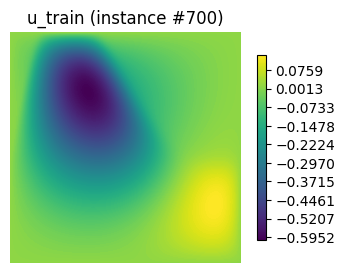

In [ ]:
# Print snapshot

index = 700

plt.figure(figsize=(4, 3))
fe.plot(u_train[index, :], V, colorbar=True)
plt.title('u_train (instance #' + str(index) + ')')
plt.show()

In [ ]:
# Traning architecture

m = 16
k = 4

# class Dense(Layer):
# 	 def __init__(self, input_dim, output_dim, activation = leakyReLU):
# 		...

# class Deconv2D(Layer):
#    def __init__(self, window, channels = (1,1), stride = 1, padding = 0, groups = 1, dilation = 1, activation = leakyReLU):
# 		...
# torch.nn.ConvTranspose2d(channels[0], channels[1], window, stride = stride, padding = padding, groups = groups, dilation = dilation)
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)

# The input and output dimensions are written in the form height x width x channels (vectors reshaped in 3D tensors)

# class Reshape(Weightless):
#    ...
#  Note: as all DNN modules, it operates in batches, i.e.: it expects an input of shape (batch_size, d1,..., dk)
#        and it outputs a corresponding tensor of shape (batch_size, p1,..., pj), where self.newdim = (p1,...,pj).
#        That is, all input instances of dimension (d1,..., dk) are reshaped independently.
#        Note that, for this to work, one must ensure that d1*...*dk = p1*...*pj.

# torch.set_default_dtype(torch.float16)

psi_prime = Dense(Nh, 4)

print("Trainable parameters:")

print(" Encoder: ", psi_prime.dof())

psi = Dense(4, 100 * m) + \
	  Reshape(4 * m, 5, 5) + \
	  Deconv2D(11, (4 * m, 2 * m), 2) + \
	  Deconv2D(10, (2 * m, m), 2) + \
      Deconv2D(11, (m, 1), 2, activation=None) + \
	  Reshape(-1)

print(" Decoder: ", psi.dof())

phi = Dense(4, 50 * k) + \
	  Dense(50 * k, 50 * k) + \
	  Dense(50 * k, 4)

print(" Dense NN: ", phi.dof())

Trainable parameters:
 Encoder:  40808
 Decoder:  308993
 Dense NN:  42004


In [ ]:
# Move data to the GPU

u_train = GPU.tensor(u_train)
u_test = GPU.tensor(u_test)
mu_train = GPU.tensor(mu_train)
mu_test = GPU.tensor(mu_test)

In [ ]:
# Train the autoencoder to learn the identity (nonlinear dimensionality reduction)

print('Training autoencoder...')

autoencoder = psi_prime + psi																# Autoencoder architecture
autoencoder = DFNN(autoencoder)
autoencoder.He()																			# He initialization

# def train(self, mu, u, ntrain, epochs, optim = torch.optim.LBFGS, lr = 1, loss = None, error = None, nvalid = 0,
#           verbose = True, refresh = True, notation = 'e', title = None, batchsize = None, slope = 1.0)

# Learning rate, minibatch?

autoencoder.to(device)

autoencoder.train(u_train, u_train, ntrain=training_size, epochs=200, loss=mre(euclidean), verbose=True)

		Train		Test
Epoch 200:	4.48e-02	nan.

Training complete. Elapsed time: 11 minutes 40.75 seconds.


In [ ]:
# Use the trained encoder to generate the reduced order version of the dataset

print('Generating reduced order training dataset...')

autoencoder.freeze()

psi_prime.eval()

with torch.no_grad():
  u_train_ro = psi_prime(u_train)

Generating reduced order training dataset...


In [ ]:
# Use the reduced dataset to train the dense NN mapping the parameters to the reduced order solution

print('Learning map from parameters to solutions...')

phi = DFNN(phi)
phi.He()																			# He initialization

phi.to(device)

phi.train(mu_train, u_train_ro, ntrain=training_size, epochs=200, loss=mse(euclidean), verbose=True)

		Train		Test
Epoch 200:	2.23e-01	nan.

Training complete. Elapsed time: 59.81 seconds.


In [ ]:
# Use the decoder to restore the full order solution

phi.eval()
psi.eval()

with torch.no_grad():
  u_train_pred = psi(phi(mu_train))

In [ ]:
# Compute the relative error

error_train = torch.norm(u_train - u_train_pred, dim=1) / torch.norm(u_train, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))

Relative training error: 6.20%


In [ ]:
# Apply the model to the test set

with torch.no_grad():
  u_test_pred = psi(phi(mu_test))

error_test = torch.norm(u_test - u_test_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative test error: 7.01%


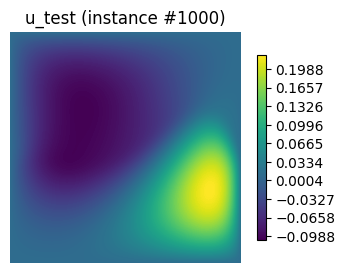

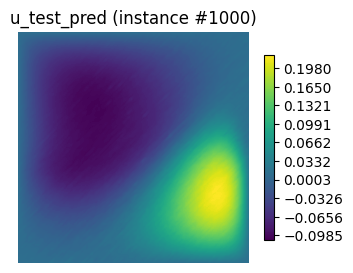

In [ ]:
# Plot some results

index = 1000

plt.figure(figsize=(4, 3))
fe.plot(u_test[index, :], V, colorbar=True)
plt.title('u_test (instance #' + str(index) + ')')

plt.figure(figsize=(4, 3))
fe.plot(u_test_pred[index, :], V, colorbar=True)
plt.title('u_test_pred (instance #' + str(index) + ')')

plt.show()

In [ ]:
# Save encoder, decoder, and dense NN

print("Encoder state_dict:")
for param_tensor in psi_prime.state_dict():
    print(param_tensor, "\t", psi_prime.state_dict()[param_tensor].size())

print("Decoder state_dict:")
for param_tensor in psi.state_dict():
    print(param_tensor, "\t", psi.state_dict()[param_tensor].size())

print("Dense NN state_dict:")
for param_tensor in phi.state_dict():
    print(param_tensor, "\t", phi.state_dict()[param_tensor].size())

torch.save(psi_prime.state_dict(), './psi_prime')
torch.save(psi.state_dict(), './psi')
torch.save(phi.state_dict(), './phi')

Encoder state_dict:
lin.weight 	 torch.Size([4, 10201])
lin.bias 	 torch.Size([4])
Decoder state_dict:
0.lin.weight 	 torch.Size([1600, 4])
0.lin.bias 	 torch.Size([1600])
2.deconv.weight 	 torch.Size([64, 32, 11, 11])
2.deconv.bias 	 torch.Size([32])
3.deconv.weight 	 torch.Size([32, 16, 10, 10])
3.deconv.bias 	 torch.Size([16])
4.deconv.weight 	 torch.Size([16, 1, 11, 11])
4.deconv.bias 	 torch.Size([1])
Dense NN state_dict:
0.0.0.lin.weight 	 torch.Size([200, 4])
0.0.0.lin.bias 	 torch.Size([200])
0.0.1.lin.weight 	 torch.Size([200, 200])
0.0.1.lin.bias 	 torch.Size([200])
0.0.2.lin.weight 	 torch.Size([4, 200])
0.0.2.lin.bias 	 torch.Size([4])


In [ ]:
# Load encoder, decoder, and dense NN

psi_prime_rel = Dense(Nh, 4)

psi_rel = Dense(4, 100 * m) + \
	        Reshape(4 * m, 5, 5) + \
	        Deconv2D(11, (4 * m, 2 * m), 2) + \
	        Deconv2D(10, (2 * m, m), 2) + \
          Deconv2D(11, (m, 1), 2, activation=None) + \
	        Reshape(-1)

#phi_rel = Dense(4, 50 * k) + \
#	        Dense(50 * k, 50 * k) + \
#	        Dense(50 * k, 4)

psi_prime_rel.load_state_dict(torch.load('./psi_prime'))
psi_rel.load_state_dict(torch.load('./psi'))
#phi_rel.load_state_dict(torch.load('./phi'))

psi_prime_rel.to(device)
psi_rel.to(device)
#phi_rel.to(device)

psi_prime_rel.eval()
psi_rel.eval()
#phi_rel.eval()

Consecutive(
  (0): Dense(
    (rho): LeakyReLU(negative_slope=0.1)
    (lin): Linear(in_features=4, out_features=1600, bias=True)
  )
  (1): Reshape(
    (rho): None
  )
  (2): Deconv2D(
    (rho): LeakyReLU(negative_slope=0.1)
    (deconv): ConvTranspose2d(64, 32, kernel_size=(11, 11), stride=(2, 2))
  )
  (3): Deconv2D(
    (rho): LeakyReLU(negative_slope=0.1)
    (deconv): ConvTranspose2d(32, 16, kernel_size=(10, 10), stride=(2, 2))
  )
  (4): Deconv2D(
    (rho): Identity()
    (deconv): ConvTranspose2d(16, 1, kernel_size=(11, 11), stride=(2, 2))
  )
  (5): Reshape(
    (rho): None
  )
)

In [ ]:
# Use reloaded models

# Check if the reduced order dataset is the same (true if an empty tensor is printed)

with torch.no_grad():
  u_train_ro_rel = psi_prime_rel(u_train)

combined = torch.cat((u_train_ro, u_train_ro_rel))
uniques, counts = combined.unique(return_counts=True)
difference = uniques[counts == 1]
print(difference)

# Check if the predictions on the test set are the same (true if if an empty tensor is printed)

with torch.no_grad():
  #u_test_pred_rel = psi_rel(phi_rel(mu_test))
  u_test_pred_rel = psi_rel(phi(mu_test))

combined = torch.cat((u_test_pred, u_test_pred_rel))
uniques, counts = combined.unique(return_counts=True)
difference = uniques[counts == 1]
print(difference)
print(len(difference))

tensor([], device='cuda:0')
tensor([-0.9660, -0.9660, -0.9614,  ...,  0.3870,  0.4006,  0.4006],
       device='cuda:0')
24148450
